In [1]:
import copy
import torch
import torch.nn.functional as F

import random
import pprint
import numpy as np
import copy
import os
os.sys.path.append('../')
from rotm2euler import *
from experiment_utils import *
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import collections as mc
from collections import defaultdict
import pdb

seed = 732
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# pretty print
pp = pprint.PrettyPrinter(indent=2)

## Input Data

In [2]:
### get pair id
pair_path = '/viscompfs/users/sawang/ScanNet/pair_list.txt'
f = open(pair_path)
lines = f.readlines()
lines[9995:10000]

['scene0001_01 1190-1200-1213 \n',
 'scene0001_01 1190-1201-1211 \n',
 'scene0001_01 1190-1202-1212 \n',
 'scene0001_01 1190-1203-1217 \n',
 'scene0001_01 1192-1204-1217 \n']

In [3]:
def input_data(tgt_id, src0_id, src1_id, dataset_dir, gt_dir, H, W):
    data_dict = dict()
    image = cv2.imread(os.path.join(dataset_dir, scene, 'color', str(tgt_id) + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ori_H, ori_W, _ = image.shape
    image = cv2.resize(image, (320, 240))
    data_dict['tgt_RGB'] = image

    image = cv2.imread(os.path.join(dataset_dir, scene, 'color', str(src0_id) + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240))
    data_dict['src0_RGB'] = image

    image = cv2.imread(os.path.join(dataset_dir, scene, 'color', str(src1_id) + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240))
    data_dict['src1_RGB'] = image

    image = cv2.imread(os.path.join(gt_dir, scene, 'depth_interp', str(tgt_id) + ".png"), cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (320, 240))
    data_dict['depth'] = image / 1000

    #image = cv2.imread(os.path.join('/viscompfs/users/sawang/testnormal_2.png'), cv2.IMREAD_UNCHANGED)
    #image = cv2.resize(image, (320, 240)) / 255
    #image = unplot_normal(image)
    #data_dict['tgt_norm'] = image
    image = cv2.imread(os.path.join('/viscompfs/users/sawang/normal_sample/testnormal_2.png'), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240)) / 255
    image = unplot_normal(image)
    data_dict['tgt_norm'] = image

    image = cv2.imread(os.path.join('/viscompfs/users/sawang/normal_sample/testnormal_1.png'), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240)) / 255
    image = unplot_normal(image)
    data_dict['src0_norm'] = image

    image = cv2.imread(os.path.join('/viscompfs/users/sawang/normal_sample/testnormal_3.png'), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240)) / 255
    image = unplot_normal(image)
    data_dict['src1_norm'] = image

    mat = np.loadtxt(os.path.join(dataset_dir, scene, 'intrinsic', 'intrinsic_color.txt'))
    scale_x, scale_y = H / ori_H, W / ori_W
    mat[0, 0], mat[0, 2] = mat[0, 0] * scale_x, mat[0, 2] * scale_x
    mat[1, 1], mat[1, 2] = mat[1, 1] * scale_y, mat[1, 2] * scale_y
    data_dict['K'] = mat
    print("intrinsic: \n", mat)

    mat = np.loadtxt(os.path.join(dataset_dir, scene, 'intrinsic', 'intrinsic_depth.txt'))
    scale_x, scale_y = H / ori_H, W / ori_W
    mat[0, 0], mat[0, 2] = mat[0, 0] * scale_x, mat[0, 2] * scale_x
    mat[1, 1], mat[1, 2] = mat[1, 1] * scale_y, mat[1, 2] * scale_y
    data_dict['K_d'] = mat
    print("intrinsic (depth): \n", mat)

    pose_path = '/viscompfs/users/sawang/ScanNet/data_pose/' + scene + '.txt'
    f = open(pose_path)
    pose_all = f.readlines()

    for p in pose_all:
        char = p.split(" ")
        if char[0] == str(tgt_id) and char[1] == str(src1_id):
            data_dict['pose1'] = untransform(np.array([float(c.replace(",", "")) for c in char[2:]]))
            print("pose1: \n", data_dict['pose1'])
        elif char[0] == str(src0_id) and char[1] == str(tgt_id):
            tmp = np.array([float(c.replace(",", "")) for c in char[2:]])
            tmp = untransform(tmp)
            pose_inv = inversePose(tmp)
            data_dict['pose0'] = pose_inv
            print("pose0: \n", data_dict['pose0'])
    return data_dict

In [4]:
tgt_id, src0_id, src1_id = 1200, 1190, 1213
H, W = 240, 320
scene = 'scene0001_01'
dataset_dir = '/viscompfs/users/sawang/ScanNet/data/scans/'
gt_dir = '/viscompfs/users/sawang/ScanNet/data_gt/'

data = input_data(tgt_id, src0_id, src1_id, dataset_dir, gt_dir, H, W)

intrinsic: 
 [[290.12925322   0.         160.59917355   0.        ]
 [  0.         288.93530568 119.44444444   0.        ]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]
intrinsic (depth): 
 [[143.27370372   0.          79.21487603   0.        ]
 [  0.         142.6841      59.13580247   0.        ]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]
pose0: 
 [[ 0.99720706 -0.01383514 -0.07339395  0.02787871]
 [ 0.00892915  0.99772935 -0.06675639 -0.09059185]
 [ 0.07415088  0.06591459  0.99506629  0.13103101]
 [ 0.          0.          0.          1.        ]]
pose1: 
 [[ 0.99900703 -0.03768448 -0.0237662   0.050552  ]
 [ 0.03849179  0.99866389  0.03447915  0.089673  ]
 [ 0.02243512 -0.03535972  0.99912279 -0.182378  ]
 [ 0.          0.          0.          1.        ]]


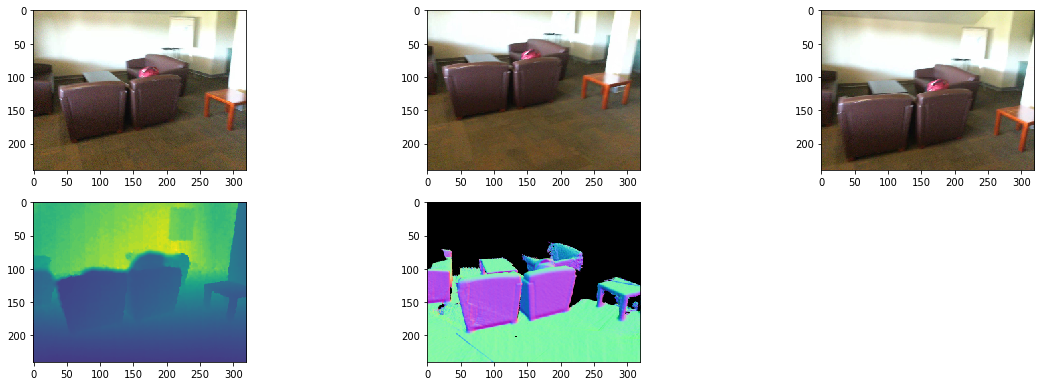

In [5]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(3, 3, 1)
ax.imshow(data['tgt_RGB'])
ax = fig.add_subplot(3, 3, 2)
ax.imshow(data['src0_RGB'])
ax = fig.add_subplot(3, 3, 3)
ax.imshow(data['src1_RGB'])
ax = fig.add_subplot(3, 3, 4)
ax.imshow(data['depth'])
ax = fig.add_subplot(3, 3, 5)
ax.imshow(plot_normal(data['tgt_norm']))

In [6]:
def sample_src_intensity(src_img, K, cam_coords, pred_pose, pred_depth, pred_norm, patch_size, dilation):
    """Computes src patch intensity
    Input:
        src_img: source image, [B, 3, H, W]
        K: intrinsics, [B, 3, 3]
        cam_coords: backprojected 3D points (K_inv @ x * d), [B, 3, H, W]
        pred_pose: predicted poses, [B, 4, 4]
        pred_depth: predicted depth, [B, 1, H, W]
        pred_norm: predicted surface normal, [B, 3, H, W]
        patch_size: patch size, integer (default = 7)
        dilation: dilation factor for patch (default = 1)
    Output:
        patch_intensities: src patch intensity, [B, 3, H - 2 * offset, W - 2 * offset, patch_size, patch_size]
        (offset = (patch size - 1) / 2)
        patch_coords: patch coordinates [B, 2, (H - 2*offset)*(W - 2*offset), patch_size * patch_size]
    """
    batch, _, height, width = pred_norm.shape
    psize_eff = 1 + dilation * (patch_size - 1) # effective patch size
    offset = (psize_eff - 1) // 2
    
    ## sample src patch intensities
    H = calculate_homography(pred_pose, K, pred_norm, cam_coords) #[B, 3, 3, H, W]

    ## cam_coords = (K_inv @ pts * d) / d 
    cam_coords = cam_coords / pred_depth

    ## get sample grid for each patch
    patch_coords = get_patch_coords(H, cam_coords, patch_size, dilation) #[B, 3, H - 2*offset, W - 2*offset, p_size, p_size]
    pcoords = copy.deepcopy(patch_coords)
    patch_coords = patch_coords.view(batch, 2, -1, patch_size * patch_size)
    patch_coords = patch_coords.permute(0, 2, 3, 1)
    
    ## normalize coordinates from sampling
    patch_coords[..., 0] /= width - 1 
    patch_coords[..., 1] /= height - 1 
    patch_coords = (patch_coords - 0.5) * 2

    ## sample intensity from src img
    patch_intensities = F.grid_sample(src_img, patch_coords, padding_mode='border')
    patch_intensities = patch_intensities.view(batch, 3, height - 2* offset, width - 2* offset, patch_size, patch_size)
    
    return patch_intensities, pcoords

def get_patch_coords(H, cam_coords, patch_size, dilation):
    """ Get the src patch coordinates 
    Input:
        H:  K(R - tn^T/d), [B, 3, 3, H, W]
        cam_coords: backprojected 3D points / d (K_inv @ x), [B, 3, H, W]
        patch_size: patch size, integer (default = 7)
        dilation: dilation factor for patch (default = 1)
    Output:
        patch_coords: sample idx for each patch, [B, 2, H - 2 * offset, W - 2 * offset, patch_size, patch_size] 
        (offset = (patch size - 1) / 2)
    """
    batch, _, height, width = cam_coords.shape
    psize_eff = 1 + dilation * (patch_size - 1) # effective patch size
    offset = (psize_eff - 1) // 2               # offset

    unfold = torch.nn.Unfold(kernel_size=(patch_size, patch_size), dilation=dilation)
    patch_coords = unfold(cam_coords) # # [B, 3*psize*psize, (H-2*offset)*(W-2*offset)]
    patch_coords = patch_coords.view(batch, 3, patch_size, patch_size, height-2*offset, width-2*offset)
    patch_coords = patch_coords.permute(0, 1, 4, 5, 2, 3) #[B, 3, H, W, patch_size, patch_size]
    H = H[:, :, :, offset:-offset, offset:-offset]
    
    patch_coords = torch.einsum("mnpqr, mpqrst -> mnqrst", H, patch_coords) #[B, 3, H, W, patch_size, patch_size]
    patch_coords = patch_coords[:, :2, :, :, :, :] / (patch_coords[:, 2:, :, :, :, :] + 1e-10) # dehomogenize
    return patch_coords

def calculate_homography(pose, K, pred_norm, cam_coords):
    """Computes the homography of each pixel 
    Input:
        K: intrinsics, [B, 3, 3]
        cam_coords: backprojected 3D points (K_inv @ x * d), [B, 3, H, W]
        pred_pose: predicted poses, [B, 4, 4]
        pred_norm: predicted surface normal, [B, 3, H, W]
    Output:
        H: sample idx for each patch, [B, 3, 3, H, W] 
    """
    B, _, H, W = pred_norm.shape

    # compute d = - (nx*x + ny*y + nz*z), [B, 1, H, W]
    d = torch.sum(pred_norm * cam_coords, dim=1, keepdim=True) * -1

    # construct homography matrix H = (R - tn^T/d), [B, 3, H, W]
    scaled_norm = pred_norm / (d + 1e-10)

    R = pose[:, :3, :3].view(B, 3, 3)
    t = pose[:, :3, 3].view(B, 3)
    R = torch.unsqueeze(torch.unsqueeze(R, -1), -1) # [B, 3, 3, 1, 1]
    R = R.repeat(1, 1, 1, H, W)
    
    # outer product: outer[m, q, n, p, r] = t[m, q] * scaled_norm[m, n, p, r]
    outer = torch.einsum('mq, mnpr -> mqnpr', t, scaled_norm)
    H = R - outer # [B, 3, 3, H, W]

    # pre-multiply with K, H = K(R - tn^T/d)
    H = torch.einsum('bcd, bdehw -> bcehw', K, H)

    return H

In [7]:
def checkSampleSrcIntensity(data):
    H, W = 240, 320
    patch_size = 3
    dilation = 2
    
    meshgrid = np.dstack(np.meshgrid(range(W), range(H)))
    meshgrid = homogenize(meshgrid).reshape((-1, 3))
    meshgrid = np.transpose(meshgrid, (1, 0))
    K_inv = np.linalg.inv(data['K'][:3, :3])
    cam_coord = data['depth'].reshape((1, -1)) * (K_inv @ meshgrid)  ## (3, H * W)
    cam_coord = cam_coord.T.reshape((H, W, 3)).astype(np.float32).transpose((2, 0, 1))
    cam_coord_ten = torch.from_numpy(cam_coord[np.newaxis, :, :, :])
    
    normal = torch.from_numpy(data['tgt_norm'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2)))
    depth = torch.from_numpy(data['depth'][np.newaxis, :, :, np.newaxis].astype(np.float32).transpose((0, 3, 1, 2)))
    pose = torch.from_numpy(data['pose0'][np.newaxis, :, :].astype(np.float32))
    intrinsics = torch.from_numpy(data['K'][np.newaxis, :3, :3].astype(np.float32))
    src_img = torch.from_numpy(data['src0_RGB'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2)))
    
    intensities, pcoords = sample_src_intensity(src_img, intrinsics, cam_coord_ten, pose, depth, normal, patch_size, dilation)
    intensities = intensities.permute(0, 2, 3, 4, 5, 1).numpy()
    return intensities, pcoords

In [8]:
def homogenize(pts):
    ones = np.ones_like(pts[:, :, 0])
    return np.dstack((pts, ones))

def warp_patch(pt, H, K, src, patch_size=7):
    xv, yv = get_meshgrid(patch_size, patch_size, pt) # x-coord, y-coord
    xv = xv.flatten()
    yv = yv.flatten()
    mesh_flatten = np.vstack([xv, yv, np.ones_like(yv)]) # [3, patch_size**2]
    ps = K @ mesh_flatten
    ps = H @ ps
    ps = ps[:2] / ps[2]
    
    patch_img = np.zeros([patch_size, patch_size, 3])
    for x in range(patch_size):
        for y in range(patch_size):
            i = y * patch_size + x
            patch_img[y, x] = bilinear_pt(ps[:, i, np.newaxis], src)
    return ps, patch_img / 255.0 # convert to [0, 1] float image

def ssim_patch(x, y):
    """Computes the patch SSIM loss
        Input:
        x: [B, 3, H, W, patch_size, patch_size]
        y: [B, 3, H, W, patch_size, patch_size]
        Output:
        SSIM: SSIM of all patches, [B, 1, H, W]
    """
    C1, C2 = 0.01 ** 2, 0.03 ** 2
    B, _, H, W, size, _ = x.shape
    x = x.contiguous().view(B, 3, H, W, size * size)
    y = y.contiguous().view(B, 3, H, W, size * size)

    mu_x = torch.mean(x, dim=4)
    mu_y = torch.mean(y, dim=4)

    sig_x = torch.mean(x ** 2, dim=4) - mu_x ** 2
    sig_y = torch.mean(y ** 2, dim=4) - mu_y ** 2
    sig_xy = torch.mean(x * y, dim=4) - mu_x * mu_y

    SSIM_n = (2 * mu_x * mu_y + C1) * (2 * sig_xy + C2)
    SSIM_d = (mu_x ** 2 + mu_y ** 2 + C1) * (sig_x + sig_y + C2) + 1e-10
    SSIM = torch.clamp((1 - SSIM_n / SSIM_d) / 2, 0, 1)

    SSIM = torch.mean(SSIM, dim=1, keepdim=True)
    return SSIM

def compute_patch_difference(tgt_img, src_img, K, cam_coords,
                             pred_pose, pred_depth, pred_norm,
                             patch_size=7, dilation=1, type="median"):
    """Computes the patch intensity difference between tgt and src
    Input:
        tgt_img: target image, [B, 3, H, W]
        src_img: source image, [B, 3, H, W]
        K: intrinsics, [B, 4, 4]
        cam_coords: backprojected 3D points (K_inv @ x * d), [B, 4, H * W]
        pred_pose: predicted poses, [B, 4, 4]
        pred_depth: predicted depth, [B, 1, H, W]
        pred_norm: predicted surface normal, [B, 3, H, W]
        patch_size: patch size, integer (default = 7)
        dilation: dilation factor for patch (default = 1)
    Output:
        patch_diff: patch intensity difference, value in each pixel indicates max/average intensity 
        difference for that patch. [B, 1, H, W]
    """
    batch, _, height, width = pred_norm.shape
    cam_coords = cam_coords[:, :-1, :].view(batch, 3, height, width)
    K = K[:, :3, :3]

    unfold = torch.nn.Unfold(kernel_size=(patch_size, patch_size), dilation=dilation)

    ## sample tgt patch intensities, 
    # final resulting `tgt_intensities` has shape [B, 3, H-2*offset, W-2*offset, patch_size, patch_size]
    psize_eff = 1 + dilation * (patch_size - 1) # effective patch size
    ofs = (psize_eff - 1) // 2                  # offset
    tgt_intensities = unfold(tgt_img)       # [B, 3*psize*psize, (H-2*offset)*(W-2*offset)]
    tgt_intensities = tgt_intensities.view(batch, 3, patch_size, patch_size, height-2*ofs, width-2*ofs)
    tgt_intensities = tgt_intensities.permute(0, 1, 4, 5, 2, 3) 
    
    ## sample src patch intensities, [B, 3, H - 2 * offset, W - 2 * offset, patch_size, patch_size]
    src_intensities, src_coords = sample_src_intensity(src_img, K, cam_coords, pred_pose, pred_depth, pred_norm, patch_size, dilation)

    ## patch_difference
    if type == "mean":
        patch_abs = torch.abs(tgt_intensities - src_intensities).mean(dim=1, keepdim=True).mean(dim=(4, 5)) # [B, 1, H - 2*offset, W - 2*offset]
    else:
        patch_abs = torch.abs(tgt_intensities - src_intensities).mean(dim=1, keepdim=True)
        patch_abs = patch_abs.view(batch, 1, height-2*ofs, width-2*ofs, -1) # [B, 1, H-2*offset, W-2*offset, patch_size * patch_size]
        if type == "max":
            patch_abs, _ = patch_abs.max(dim=-1) # [B, 1, H-2*offset, W-2*offset]
        elif type == "median":
            patch_abs, _ = patch_abs.median(dim=-1)
        else:
            raise ValueError("Operation type not recognized.")

    patch_diff = patch_abs * 0.15 + ssim_patch(tgt_intensities, src_intensities) * 0.85
    
    #print('patch_size: {}, dilation:{}, shape:{}'.format(patch_size, dilation, patch_diff.shape))
    return patch_diff, src_coords

def compare_patch_difference(data, fake_norm, psize, dilation, reduce_type):
    H, W = 240, 320
    
    meshgrid = np.dstack(np.meshgrid(range(W), range(H)))
    meshgrid = homogenize(meshgrid).reshape((-1, 3))
    meshgrid = np.transpose(meshgrid, (1, 0))
    K_inv = np.linalg.inv(data['K'][:3, :3])
    cam_coord = data['depth'].reshape((1, -1)) * (K_inv @ meshgrid)  ## (3, H * W)
    cam_coord = cam_coord.T.reshape((H, W, 3)).astype(np.float32).transpose((2, 0, 1))
    cam_coord = np.concatenate([cam_coord, np.ones([1, H, W])], axis=0).astype(np.float32)
    cam_coord_ten = torch.from_numpy(cam_coord[np.newaxis, :, :, :]).cuda()
    
    fake_norm = torch.from_numpy(fake_norm[np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2))).cuda()
    normal = torch.from_numpy(data['tgt_norm'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2))).cuda()
    depth = torch.from_numpy(data['depth'][np.newaxis, :, :, np.newaxis].astype(np.float32).transpose((0, 3, 1, 2))).cuda()
    pose = torch.from_numpy(data['pose0'][np.newaxis, :, :].astype(np.float32)).cuda()
    intrinsics = torch.from_numpy(data['K'][np.newaxis, :3, :3].astype(np.float32)).cuda()
    src_img = torch.from_numpy(data['src0_RGB'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2))).cuda() / 255.0
    tgt_img = torch.from_numpy(data['tgt_RGB'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2))).cuda() / 255.0
    
    loss_gt, _ = compute_patch_difference(tgt_img, src_img,
                                       intrinsics, cam_coord_ten, pose, 
                                       depth, normal, patch_size=psize, dilation=dilation, type=reduce_type)
    loss_fk, _ = compute_patch_difference(tgt_img, src_img,
                                       intrinsics, cam_coord_ten, pose, 
                                       depth, fake_norm, patch_size=psize, dilation=dilation, type=reduce_type)
    return loss_gt, loss_fk

In [9]:
intensities, _ = checkSampleSrcIntensity(data)

### Normals to be tested 

In [10]:
def add_noise(gt_normal, mu=0, sigma=1):
    # standard normal distribution with mean 0, variance 1
    noise = sigma * np.random.randn(*gt_normal.shape) + mu
    noisy_normal = gt_normal + noise
    noisy_normal /= np.linalg.norm(noisy_normal, axis=2, keepdims=True)
    return noisy_normal

In [11]:
ones = np.ones([H, W])
zeros = np.zeros([H, W])

normal_dict = {
    'neg_x': np.dstack([-ones, zeros, zeros]),
    'neg_z': np.dstack([zeros, zeros, -ones]),
    'gt': data['tgt_norm'],
    'gt_noise_001': add_noise(data['tgt_norm'], mu=0, sigma=0.01),
    'gt_noise_010': add_noise(data['tgt_norm'], mu=0, sigma=0.1)
} 

In [12]:
assert np.linalg.norm(normal_dict['gt_noise_001'], axis=2).all() == 1
assert np.linalg.norm(normal_dict['gt_noise_010'], axis=2).all() == 1

### Function for plotting

In [13]:
def test_and_plot(data, input_norm, psize_lst, plt_title="Plot"):
    """psize_lst: list where each element is formated as (patch_size, dilation)"""
    # run test
    reduce_lst = ["mean", "median", "max"]
    results = defaultdict(list)
    first_iter = True
    for rtype in reduce_lst:
        for (psize, dil) in psize_lst:
            loss_gt, loss_fk = compare_patch_difference(data, input_norm,
                                                        psize=psize,
                                                        dilation=dil,
                                                        reduce_type=rtype)
            loss_fk_mean = torch.mean(loss_fk, dim=(2, 3))
            loss_gt_mean = torch.mean(loss_gt, dim=(2, 3))
            loss_diff = torch.abs(loss_gt_mean - loss_fk_mean).cpu().numpy()[0, 0]
            results[rtype].append(loss_diff)
            
            if first_iter:
                first_iter = False
                print('Loss Fake: {}, Loss Gt: {}'.format(loss_fk_mean, loss_gt_mean))
    
    # plot results
    fs = 14
    plt.figure(figsize=(15, 10))
    plt.title(plt_title, fontsize=fs+2)
    plt.xlabel('Patch Size', fontsize=fs+2)
    plt.ylabel('Loss', fontsize=fs+2)
    
    xticks = ["p{}d{}".format(*tup) for tup in psize_lst]
    x = list(range(len(psize_lst)))
    plt.xticks(x, xticks)
    
    for rtype in reduce_lst:
        plt.plot(x, results[rtype], label=rtype)
    plt.legend()
    plt.show()
    
    return results

### Sanity Check: Calculate Loss with Ground Truth Normal

Loss Fake: tensor([[0.1190]], device='cuda:0'), Loss Gt: tensor([[0.1190]], device='cuda:0')


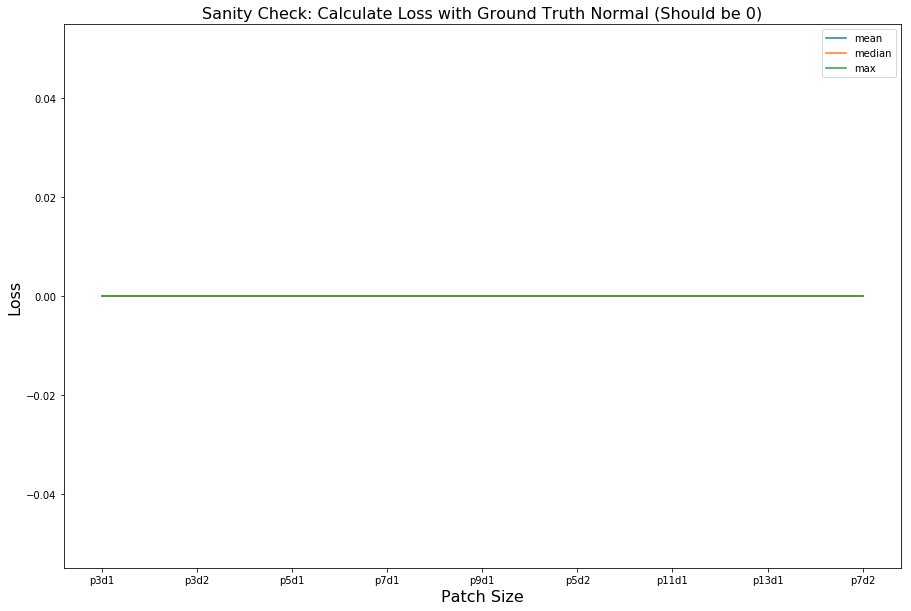

defaultdict(list,
            {'mean': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             'median': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             'max': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]})

In [14]:
psize_lst = [(3, 1), (3, 2), (5, 1), (7, 1), (9, 1), (5, 2), (11, 1), (13, 1), (7, 2)]
test_and_plot(data, normal_dict['gt'], 
              psize_lst,
              "Sanity Check: Calculate Loss with Ground Truth Normal (Should be 0)")

### Case: Normal at -z direction

In [15]:
data_copy = copy.deepcopy(data)
data_copy['tgt_norm'] = normal_dict['neg_z']
intensities, pcoords = checkSampleSrcIntensity(data_copy)

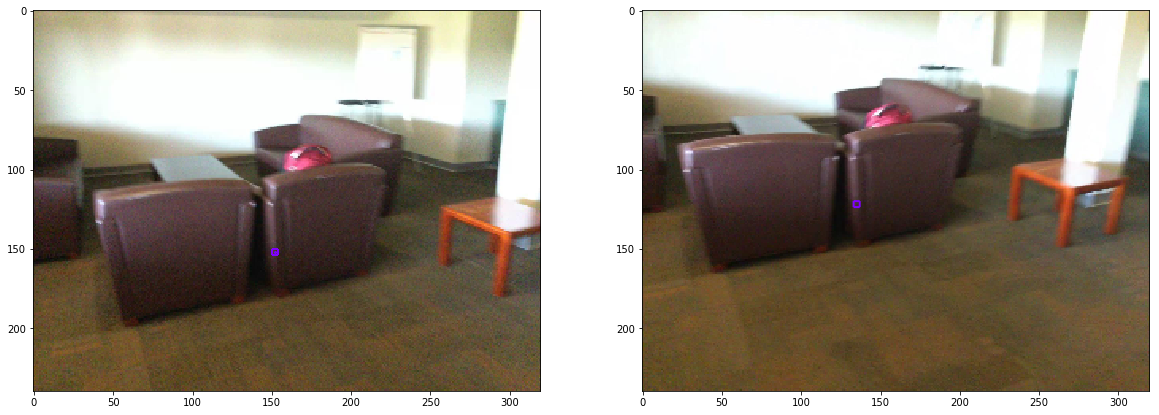

In [16]:
patch_centers=np.array([[152], [152]])
_, n_pts = patch_centers.shape
ofs = 2
patch_coords = pcoords

color=cm.rainbow(np.linspace(0, 1, n_pts))
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(data['tgt_RGB'])
ax2.imshow(data['src0_RGB'])
for i, c in zip(range(n_pts), color):
    ctr_x, ctr_y = patch_centers[:, i].astype(int)

    # plot patch centers on target image
    ax1.scatter(ctr_x, ctr_y, color=c, s=4)

    # plot patch boundaries on target image
    upper_left  = (ctr_x-ofs, ctr_y-ofs)
    upper_right = (ctr_x+ofs, ctr_y-ofs)
    lower_left =  (ctr_x-ofs, ctr_y+ofs)
    lower_right = (ctr_x+ofs, ctr_y+ofs)
    lines = [[upper_left, upper_right], 
            [upper_right, lower_right],
            [lower_right, lower_left],
            [lower_left, upper_left]]
    lc = mc.LineCollection(lines, colors=c, linewidths=2)
    ax1.add_collection(lc)

    # plot patch centers on source image
#     ctr_x_s, ctr_s_y = pixel_coords[0, :, ctr_y, ctr_x]
#     ax2.scatter(ctr_x_s, ctr_s_y, color=c, s=4)

    # plot patch boundaries on source image
    ctr_x -= ofs
    ctr_y -= ofs
    coord = patch_coords[0, :, ctr_y, ctr_x, :, :].numpy() # [2, patch_size, patch_size]

    # for plotting lines, refer to 
    # https://stackoverflow.com/questions/21352580/matplotlib-plotting-numerous-disconnected-line-segments-with-different-colors
    upper_left  = coord[:,  0,  0]
    upper_right = coord[:,  0, -1]
    lower_left  = coord[:, -1,  0]
    lower_right = coord[:, -1, -1]
    lines = [[upper_left, upper_right], 
            [upper_right, lower_right],
            [lower_right, lower_left],
            [lower_left, upper_left]]
    lc = mc.LineCollection(lines, colors=c, linewidths=2)
    ax2.add_collection(lc)
plt.show()

Loss Fake: tensor([[0.1191]], device='cuda:0'), Loss Gt: tensor([[0.1190]], device='cuda:0')


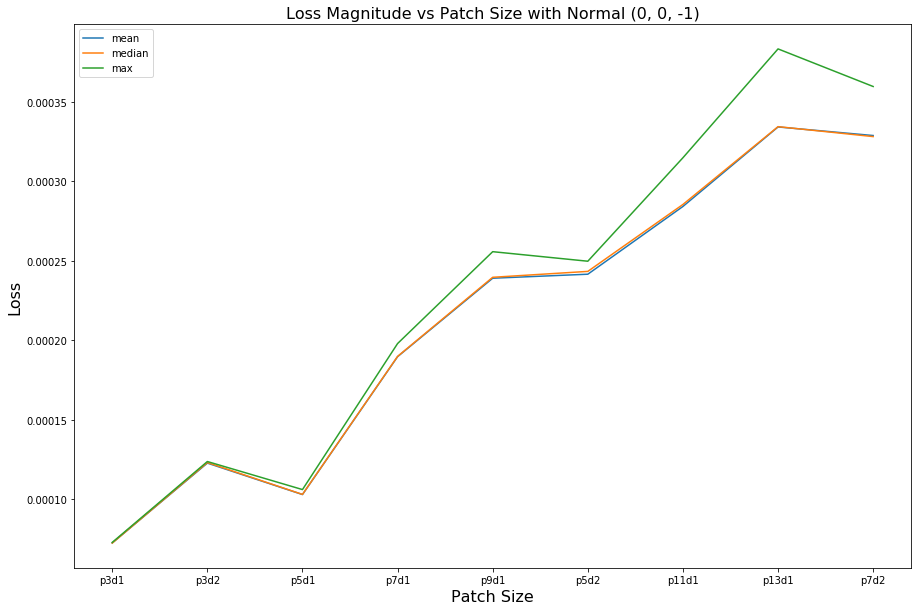

defaultdict(<class 'list'>,
            { 'max': [ 7.288158e-05,
                       0.00012376904,
                       0.00010612607,
                       0.00019800663,
                       0.00025580823,
                       0.00024980307,
                       0.00031490624,
                       0.00038339198,
                       0.00035973638],
              'mean': [ 7.253885e-05,
                        0.00012277812,
                        0.000102996826,
                        0.00018975139,
                        0.00023911148,
                        0.00024162978,
                        0.00028425455,
                        0.0003342852,
                        0.00032889098],
              'median': [ 7.2449446e-05,
                          0.00012310594,
                          0.00010308623,
                          0.0001899153,
                          0.00023969263,
                          0.00024340302,
                          0.000285

In [17]:
# calculate loss
psize_lst = [(3, 1), (3, 2), (5, 1), (7, 1), (9, 1), (5, 2), (11, 1), (13, 1), (7, 2)]
result_neg_z = test_and_plot(data, normal_dict['neg_z'], 
                              psize_lst,
                              "Loss Magnitude vs Patch Size with Normal (0, 0, -1)")
pp.pprint(result_neg_z)

### Case Normal at -x direction

In [18]:
data_copy = copy.deepcopy(data)
data_copy['tgt_norm'] = normal_dict['neg_x']
intensities, pcoords = checkSampleSrcIntensity(data_copy)

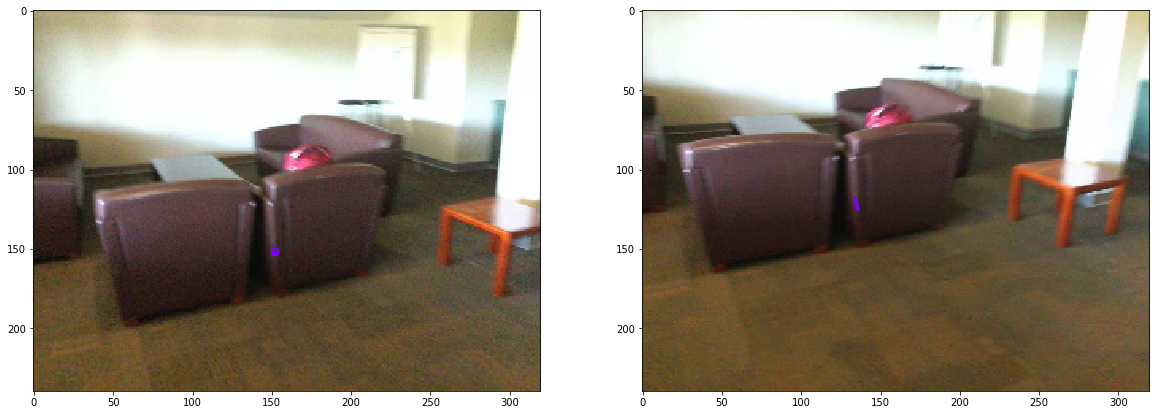

In [19]:
patch_centers=np.array([[152], [152]])
_, n_pts = patch_centers.shape
ofs = 2
patch_coords = pcoords

color=cm.rainbow(np.linspace(0, 1, n_pts))
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(data['tgt_RGB'])
ax2.imshow(data['src0_RGB'])
for i, c in zip(range(n_pts), color):
    ctr_x, ctr_y = patch_centers[:, i].astype(int)

    # plot patch centers on target image
    ax1.scatter(ctr_x, ctr_y, color=c, s=4)

    # plot patch boundaries on target image
    upper_left  = (ctr_x-ofs, ctr_y-ofs)
    upper_right = (ctr_x+ofs, ctr_y-ofs)
    lower_left =  (ctr_x-ofs, ctr_y+ofs)
    lower_right = (ctr_x+ofs, ctr_y+ofs)
    lines = [[upper_left, upper_right], 
            [upper_right, lower_right],
            [lower_right, lower_left],
            [lower_left, upper_left]]
    lc = mc.LineCollection(lines, colors=c, linewidths=2)
    ax1.add_collection(lc)

    # plot patch centers on source image
#     ctr_x_s, ctr_s_y = pixel_coords[0, :, ctr_y, ctr_x]
#     ax2.scatter(ctr_x_s, ctr_s_y, color=c, s=4)

    # plot patch boundaries on source image
    ctr_x -= ofs
    ctr_y -= ofs
    coord = patch_coords[0, :, ctr_y, ctr_x, :, :].numpy() # [2, patch_size, patch_size]

    # for plotting lines, refer to 
    # https://stackoverflow.com/questions/21352580/matplotlib-plotting-numerous-disconnected-line-segments-with-different-colors
    upper_left  = coord[:,  0,  0]
    upper_right = coord[:,  0, -1]
    lower_left  = coord[:, -1,  0]
    lower_right = coord[:, -1, -1]
    lines = [[upper_left, upper_right], 
            [upper_right, lower_right],
            [lower_right, lower_left],
            [lower_left, upper_left]]
    lc = mc.LineCollection(lines, colors=c, linewidths=2)
    ax2.add_collection(lc)
plt.show()

Loss Fake: tensor([[0.1233]], device='cuda:0'), Loss Gt: tensor([[0.1190]], device='cuda:0')


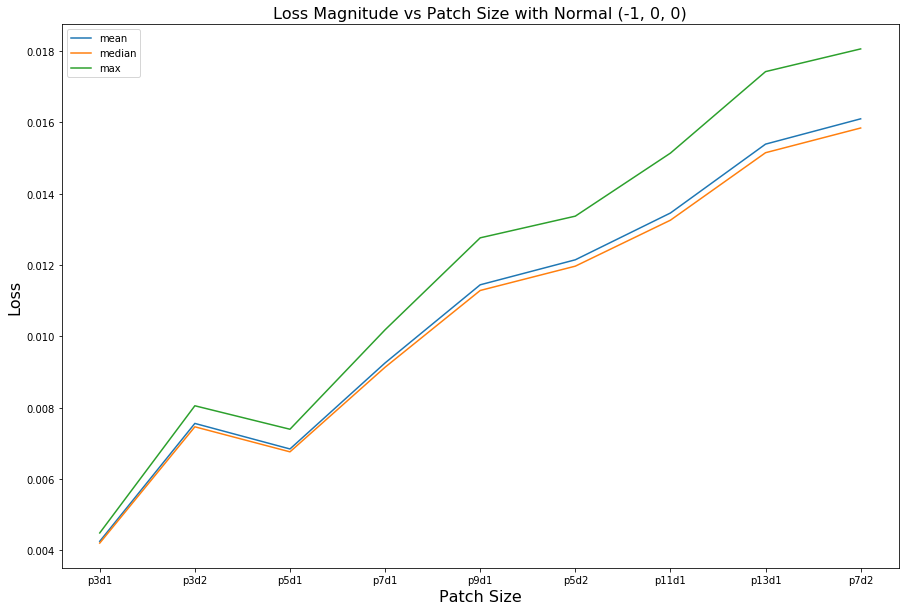

defaultdict(<class 'list'>,
            { 'max': [ 0.0044849813,
                       0.0080524385,
                       0.007393986,
                       0.01018399,
                       0.012763664,
                       0.01337187,
                       0.015140131,
                       0.017426446,
                       0.018063515],
              'mean': [ 0.0042498037,
                        0.007557258,
                        0.0068407506,
                        0.009254232,
                        0.011446044,
                        0.012147501,
                        0.013460174,
                        0.015392192,
                        0.01610227],
              'median': [ 0.0042002723,
                          0.007462509,
                          0.006760061,
                          0.009134024,
                          0.0112868175,
                          0.011969,
                          0.0132585615,
                          0.015151605,


In [20]:
# calculate loss
psize_lst = [(3, 1), (3, 2), (5, 1), (7, 1), (9, 1), (5, 2), (11, 1), (13, 1), (7, 2)]
result_neg_x = test_and_plot(data, normal_dict['neg_x'], 
                             psize_lst,
                             "Loss Magnitude vs Patch Size with Normal (-1, 0, 0)")
pp.pprint(result_neg_x)

### Case: Ground Truth Normal + Gaussian Noise (mu=0, sigma=0.01)

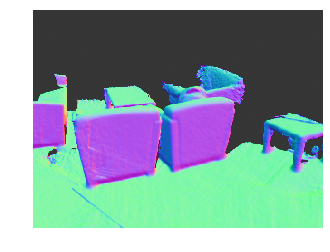

In [21]:
plt.imshow(plot_normal(normal_dict['gt_noise_001']))
plt.axis('off')
plt.show()

Loss Fake: tensor([[0.1190]], device='cuda:0'), Loss Gt: tensor([[0.1190]], device='cuda:0')


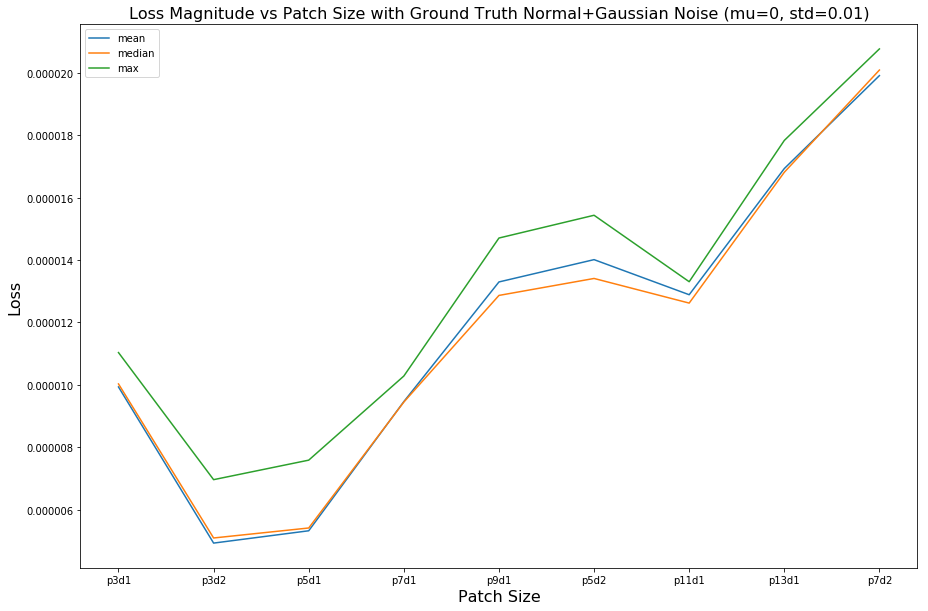

defaultdict(<class 'list'>,
            { 'max': [ 1.103431e-05,
                       6.9588423e-06,
                       7.584691e-06,
                       1.0281801e-05,
                       1.4707446e-05,
                       1.5437603e-05,
                       1.3306737e-05,
                       1.783669e-05,
                       2.0772219e-05],
              'mean': [ 9.931624e-06,
                        4.924834e-06,
                        5.3197145e-06,
                        9.462237e-06,
                        1.3299286e-05,
                        1.4014542e-05,
                        1.2889504e-05,
                        1.693517e-05,
                        1.9915402e-05],
              'median': [ 1.00284815e-05,
                          5.0887465e-06,
                          5.4091215e-06,
                          9.447336e-06,
                          1.2867153e-05,
                          1.3411045e-05,
                          1.26212835e-

In [22]:
# calculate loss
psize_lst = [(3, 1), (3, 2), (5, 1), (7, 1), (9, 1), (5, 2), (11, 1), (13, 1), (7, 2)]
plt_title = "Loss Magnitude vs Patch Size with Ground Truth Normal+Gaussian Noise (mu=0, std=0.01)"
result_noise_0 = test_and_plot(data, normal_dict['gt_noise_001'], 
                              psize_lst,
                              plt_title)
pp.pprint(result_noise_0)

### Case: Ground Truth Normal + Gaussian Noise (mu=0, std=0.1)

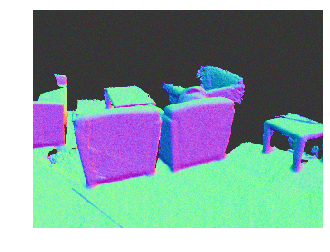

In [23]:
plt.imshow(plot_normal(normal_dict['gt_noise_010']))
plt.axis('off')
plt.show()

Loss Fake: tensor([[0.1191]], device='cuda:0'), Loss Gt: tensor([[0.1190]], device='cuda:0')


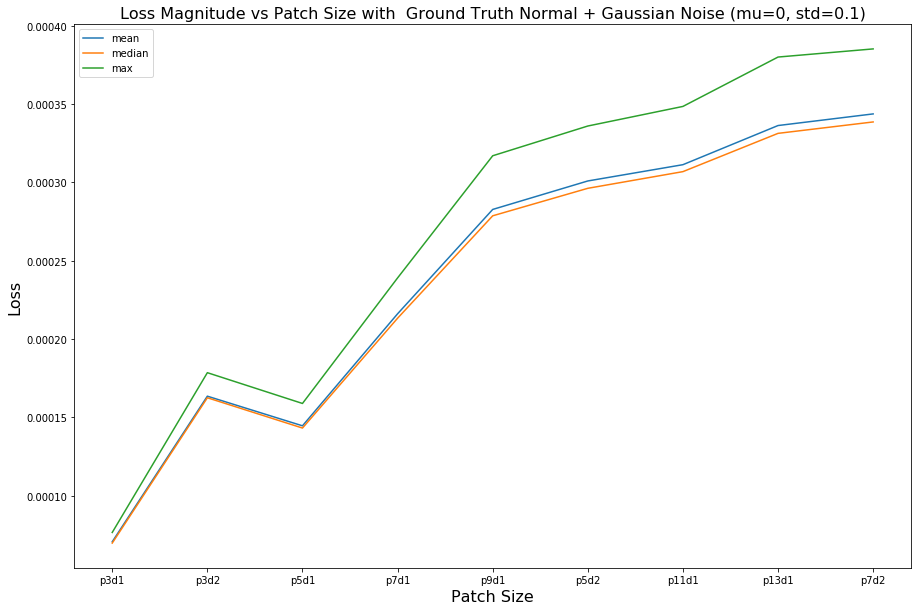

defaultdict(<class 'list'>,
            { 'max': [ 7.658452e-05,
                       0.00017854571,
                       0.00015890598,
                       0.00023901463,
                       0.0003169626,
                       0.00033594668,
                       0.00034844875,
                       0.00037995726,
                       0.0003851503],
              'mean': [ 7.0653856e-05,
                        0.00016355515,
                        0.00014464557,
                        0.00021612644,
                        0.00028271228,
                        0.00030088425,
                        0.00031127036,
                        0.00033625215,
                        0.00034367293],
              'median': [ 6.980449e-05,
                          0.00016254187,
                          0.00014321506,
                          0.00021330267,
                          0.0002786517,
                          0.00029619783,
                          0.00030683

In [24]:
# calculate loss
psize_lst = [(3, 1), (3, 2), (5, 1), (7, 1), (9, 1), (5, 2), (11, 1), (13, 1), (7, 2)]
plt_title = "Loss Magnitude vs Patch Size with  Ground Truth Normal + Gaussian Noise (mu=0, std=0.1)"
result_noise_1 = test_and_plot(data, normal_dict['gt_noise_010'], 
                                psize_lst,
                                plt_title)

pp.pprint(result_noise_1)

## How Loss Values Increase As Normal Error Increases

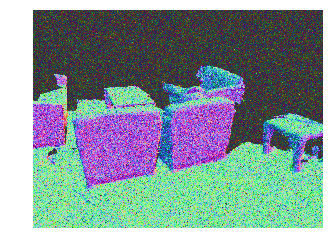

In [48]:
noisy_normal = add_noise(data['tgt_norm'], mu=0, sigma=0.5)
assert np.linalg.norm(noisy_normal, axis=2).all() == 1
plt.imshow(plot_normal(noisy_normal))
plt.axis('off')
plt.show()

In [26]:
def test_and_plot_normal_error(data, psize_lst, mask=None, plt_title="Plot"):
    sigma_lst = np.arange(0, 1.01, 0.01).tolist()
    #sigma_lst = np.arange(0, 6.5, 0.5).tolist()
    reduce_lst = ["mean", "median", "max"]
    normal_lst = [add_noise(data['tgt_norm'], mu=0, sigma=sig) for sig in sigma_lst]
    
     
        
    # run test
    results = defaultdict(list)
    labels = []
    first_iter = True
    for (psize, dil) in  psize_lst: 
        print("Running p{}d{}...".format(psize, dil))
        
        if mask is not None:
            effective_patch_size = 1 + dil * (psize - 1)
            offset = (effective_patch_size - 1) // 2
            mask_crop = mask[:, :, offset:-offset, offset:-offset]
        
        for rtype in reduce_lst:
            for input_norm in normal_lst:
                _, loss_fk = compare_patch_difference(data, input_norm,
                                                            psize=psize,
                                                            dilation=dil,
                                                            reduce_type=rtype)
                if mask is not None:
                    loss_fk[mask_crop] = 0
                    loss_fk_mean = loss_fk.sum() / (1-mask_crop).sum().float()
                    loss_fk_mean = loss_fk_mean.cpu().numpy()
                else:
                    loss_fk_mean = torch.mean(loss_fk, dim=(2, 3)).cpu().numpy()[0, 0]
                
                if first_iter:
                    first_iter = False
                    loss_map = loss_fk.squeeze().cpu().numpy()
                    print('Max: {}, Min: {}'.format(loss_map.max(), loss_map.min()))
                    plt.imshow(loss_map)
                    plt.axis('off')
                    plt.show()
                    
                results[(psize, dil, rtype)].append(loss_fk_mean)
            labels.append((psize, dil, rtype))
    
    # plot results
    fs = 14
    plt.figure(figsize=(15, 10))
    plt.title(plt_title, fontsize=fs+2)
    plt.xlabel('Gaussian Noise Sigma', fontsize=fs+2)
    plt.ylabel('Loss', fontsize=fs+2)
    
    #plt.xticks(np.arange(0, 1, step=0.2))
    plt.xticks(np.arange(0, 6, step=1.0))
    color=cm.rainbow(np.linspace(0, 1, len(labels)))
    
    for label, c in zip(labels, color):
        psize, dil, rtype = label
        plt.plot(sigma_lst, results[label], label="p{}d{}-{}".format(psize, dil, rtype), c=c)
    plt.legend()
    plt.show()
    
    return results

Running p3d1...
Max: 0.7486065626144409, Min: 4.9670543234014986e-09


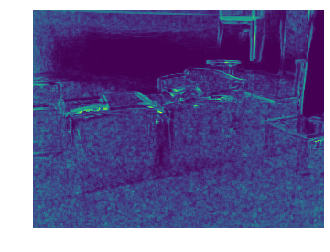

Running p3d2...
Running p5d1...
Running p7d1...
Running p9d1...
Running p5d2...
Running p11d1...
Running p13d1...
Running p7d2...


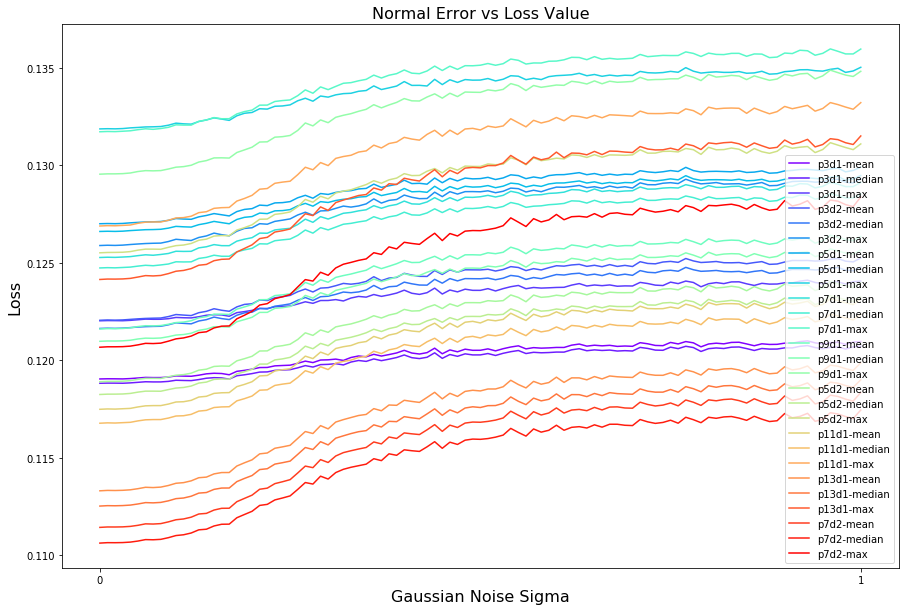

In [27]:
results = test_and_plot_normal_error(data, psize_lst,
                                     plt_title="Normal Error vs Loss Value")

In [28]:
mean_abs_diff = {}
for k, v in results.items():
    losses = copy.deepcopy(v)
    mean_abs_diff[k] = np.mean(losses)
    
mean_abs_diff = sorted(mean_abs_diff.items(), key=lambda kv: kv[1], reverse=True)

# print
print("Top 10 Configurations with Largest Absolute Difference:")
for label, abs_diff in mean_abs_diff[:10]:
    print("p{:2d}d{}-{:10s}: {}".format(*label, abs_diff))

Top 10 Configurations with Largest Absolute Difference:
p 7d1-max       : 0.13447603583335876
p 5d1-max       : 0.13389891386032104
p 9d1-max       : 0.13297925889492035
p11d1-max       : 0.13095924258232117
p 5d2-max       : 0.12913638353347778
p 5d1-mean      : 0.1288749724626541
p13d1-max       : 0.1288309246301651
p 5d1-median    : 0.12845639884471893
p 3d2-max       : 0.1281024068593979
p 7d1-mean      : 0.12778139114379883


In [29]:
np.save('patch_loss_params_results.npy', results)
#np.save('patch_loss_params_results_0.5.npy', results)

#### Plot relative difference
relative difference = (loss with fake normal - loss with gt normal) / loss with gt normal

In [30]:
results = np.load('patch_loss_params_results.npy', allow_pickle=True).item()
#results = np.load('patch_loss_params_results_0.5.npy', allow_pickle=True).item()

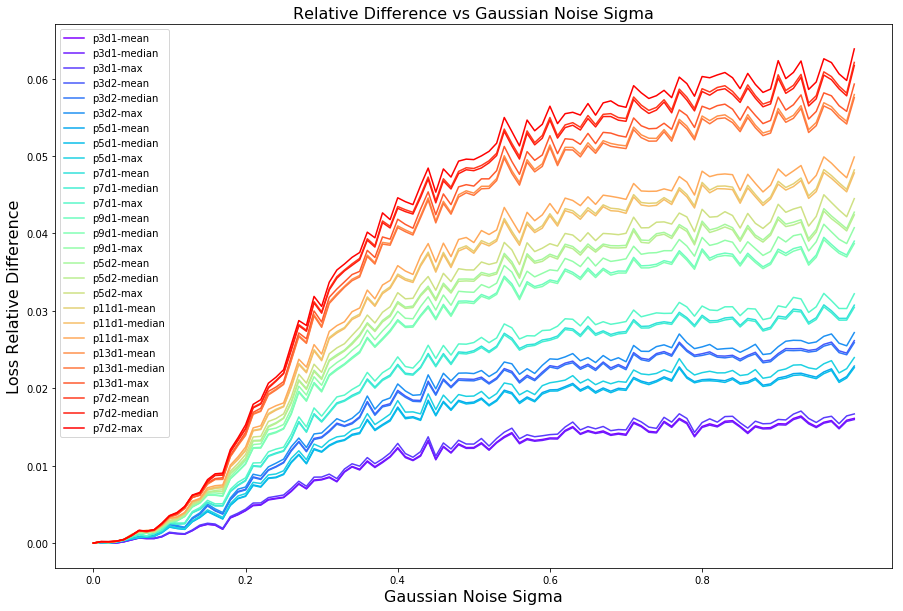

In [31]:
reduce_lst = ["mean", "median", "max"]
psize_lst = [(3, 1), (3, 2), (5, 1), (7, 1), (9, 1), (5, 2), (11, 1), (13, 1), (7, 2)]

fs = 14
plt.figure(figsize=(15, 10))
plt.title("Relative Difference vs Gaussian Noise Sigma", fontsize=fs+2)
plt.xlabel('Gaussian Noise Sigma', fontsize=fs+2)
plt.ylabel('Loss Relative Difference', fontsize=fs+2)

plt.xticks(np.arange(0, 1, step=0.2))
sigma_lst = np.arange(0, 1.01, 0.01).tolist()
#plt.xticks(np.arange(0, 6, step=0.5))
#sigma_lst = np.arange(0, 6.5, 0.5).tolist()

color=cm.rainbow(np.linspace(0, 1, len(results.keys())))

for i, (psize, dil) in enumerate(psize_lst): 
    for j, rtype in enumerate(reduce_lst):
        idx = i*len(reduce_lst) + j
        losses = copy.deepcopy(results[(psize, dil, rtype)])
        base = losses[0]
        losses = [(loss-base)/base for loss in losses]
        plt.plot(sigma_lst, losses,
                 label="p{}d{}-{}".format(psize, dil, rtype),
                 c=color[idx])
        
plt.legend()
plt.show()

In [32]:
# sort according to mean relative difference
mean_rel_diff = {}
for k, v in results.items():
    losses = copy.deepcopy(v)
    base = losses[0]
    mean_rel_diff[k] = np.mean([(loss-base)/base for loss in losses])
    
# sort 
mean_rel_diff = sorted(mean_rel_diff.items(), key=lambda kv: kv[1], reverse=True)

# print
print("Top 10 Configurations with Largest Relative Difference:")
for label, rel in mean_rel_diff[:10]:
    print("p{:2d}d{}-{:10s}: {}".format(*label, rel))

Top 10 Configurations with Largest Relative Difference:
p 7d2-max       : 0.04051918536424637
p 7d2-mean      : 0.039477284997701645
p 7d2-median    : 0.03923957049846649
p13d1-max       : 0.037789542227983475
p13d1-mean      : 0.036994460970163345
p13d1-median    : 0.03676053136587143
p11d1-max       : 0.03213447332382202
p11d1-mean      : 0.031154850497841835
p11d1-median    : 0.030942345038056374
p 5d2-max       : 0.02891026809811592


### Test Depth Discontinuity Mask

In [33]:
def get_depth_discontinuity_mask(pred_depth):
    B, C, H, W = pred_depth.shape
    sobel_kernel_y = torch.tensor([[-1., 0., 1.],
                                [-2., 0., 2.],
                                [-1., 0., 1.]]).cuda()
    sobel_kernel_y = sobel_kernel_y.expand(1, C, 3, 3)
    mask = F.conv2d(pred_depth, sobel_kernel_y, padding=1).abs()

    sobel_kernel_x = torch.tensor([[-1., -2., -1.],
                                   [0., 0., 0.],
                                   [1., 2., 1.]]).cuda()
    sobel_kernel_x = sobel_kernel_x.expand(1, C, 3, 3)
    mask = mask + F.conv2d(pred_depth, sobel_kernel_x, padding=1).abs()

    ## normalize mask
    mask_min = torch.min(torch.min(mask, dim=3, keepdim=True)[0], dim=2, keepdim=True)[0]
    mask_max = torch.max(torch.max(mask, dim=3, keepdim=True)[0], dim=2, keepdim=True)[0]
    mask = (mask - mask_min) / (mask_max - mask_min)
    return mask

torch.Size([1, 1, 240, 320]) torch.cuda.ByteTensor


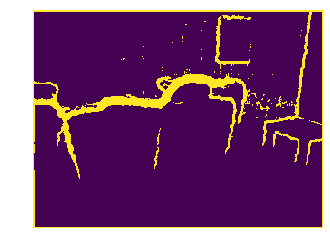

In [34]:
depth_sample = torch.from_numpy(data['depth']).view(1, 1, H, W).float().cuda()
grad_sample = get_depth_discontinuity_mask(depth_sample)
thresh_sample = 0.035
mask_tensor = (grad_sample > thresh_sample)
mask_sample = mask_tensor.float().squeeze().cpu().numpy()
print(mask_tensor.shape, mask_tensor.type())

plt.imshow(mask_sample)
plt.axis('off')
plt.show()

Running p3d1...
Max: 0.7486065626144409, Min: 0.0


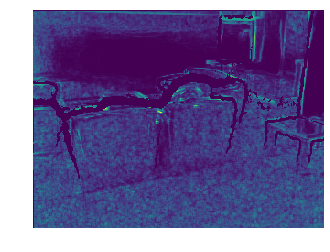

Running p3d2...
Running p5d1...
Running p7d1...
Running p9d1...
Running p5d2...
Running p11d1...
Running p13d1...
Running p7d2...


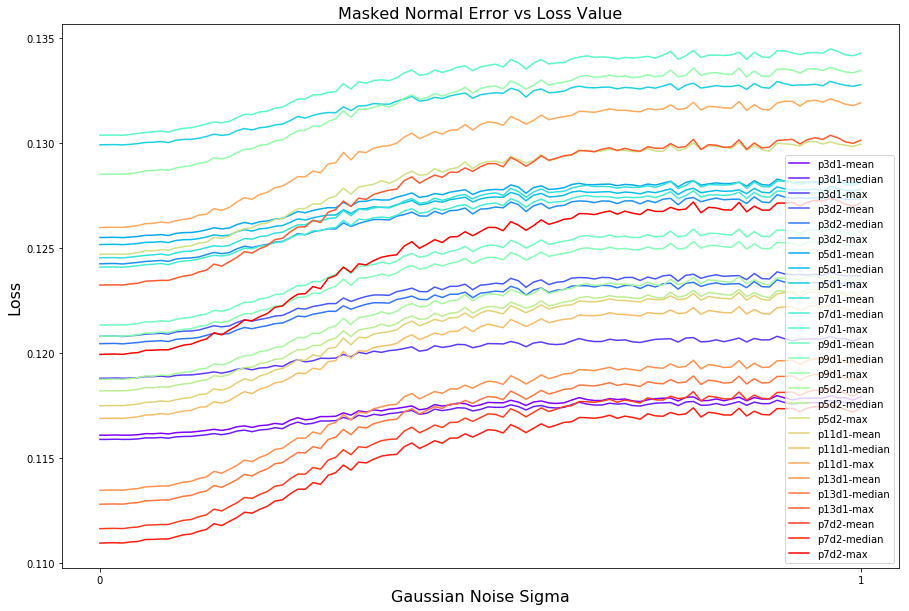

In [35]:
psize_lst = [(3, 1), (3, 2), (5, 1), (7, 1), (9, 1), (5, 2), (11, 1), (13, 1), (7, 2)]
results_masked = test_and_plot_normal_error(data, psize_lst,
                                            mask=mask_tensor,
                                            plt_title="Masked Normal Error vs Loss Value")

In [36]:
mean_abs_diff_masked = {}
for k, v in results_masked.items():
    losses = copy.deepcopy(v)
    mean_abs_diff_masked[k] = np.mean(losses)
    
mean_abs_diff_masked = sorted(mean_abs_diff_masked.items(), key=lambda kv: kv[1], reverse=True)

# print
print("Top 10 Configurations with Largest Absolute Difference:")
for label, abs_diff in mean_abs_diff_masked[:10]:
    print("p{:2d}d{}-{:10s}: {}".format(*label, abs_diff))

Top 10 Configurations with Largest Absolute Difference:
p 7d1-max       : 0.1330031454563141
p 5d1-max       : 0.13185355067253113
p 9d1-max       : 0.13179810345172882
p11d1-max       : 0.12989382445812225
p 5d2-max       : 0.12816794216632843
p13d1-max       : 0.12775377929210663
p 5d1-mean      : 0.1272890567779541
p 5d1-median    : 0.12693503499031067
p 7d1-mean      : 0.12693114578723907
p 7d1-median    : 0.12645787000656128


In [37]:
np.save('patch_loss_masked_results.npy', results_masked)

In [38]:
results_masked = np.load('patch_loss_masked_results.npy', allow_pickle=True).item()

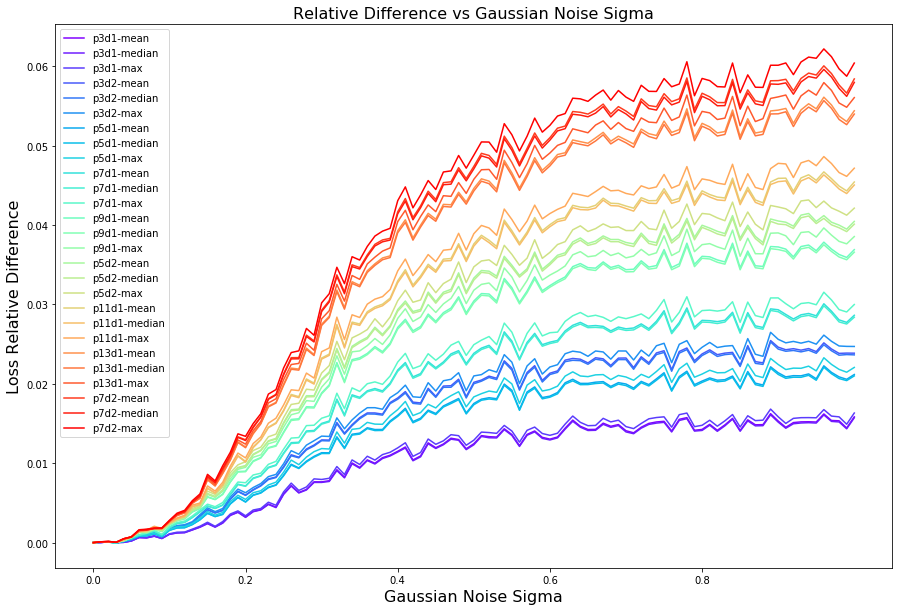

In [39]:
reduce_lst = ["mean", "median", "max"]
psize_lst = [(3, 1), (3, 2), (5, 1), (7, 1), (9, 1), (5, 2), (11, 1), (13, 1), (7, 2)]

fs = 14
plt.figure(figsize=(15, 10))
plt.title("Relative Difference vs Gaussian Noise Sigma", fontsize=fs+2)
plt.xlabel('Gaussian Noise Sigma', fontsize=fs+2)
plt.ylabel('Loss Relative Difference', fontsize=fs+2)

plt.xticks(np.arange(0, 1, step=0.2))
sigma_lst = np.arange(0, 1.01, 0.01).tolist()
#plt.xticks(np.arange(0, 6, step=0.5))
#sigma_lst = np.arange(0, 6.5, 0.5).tolist()

color=cm.rainbow(np.linspace(0, 1, len(results.keys())))

for i, (psize, dil) in enumerate(psize_lst): 
    for j, rtype in enumerate(reduce_lst):
        idx = i*len(reduce_lst) + j
        losses = copy.deepcopy(results_masked[(psize, dil, rtype)])
        base = losses[0]
        losses = [(loss-base)/base for loss in losses]
        plt.plot(sigma_lst, losses,
                 label="p{}d{}-{}".format(psize, dil, rtype),
                 c=color[idx])
        
plt.legend()
plt.show()

In [40]:
# sort according to mean relative difference
mean_rel_diff = {}
for k, v in results_masked.items():
    losses = copy.deepcopy(v)
    base = losses[0]
    mean_rel_diff[k] = np.mean([(loss-base)/base for loss in losses])
    
# sort 
mean_rel_diff = sorted(mean_rel_diff.items(), key=lambda kv: kv[1], reverse=True)

# print
print("Top 10 Configurations with Largest Relative Difference:")
for label, rel in mean_rel_diff[:10]:
    print("p{:2d}d{}-{:10s}: {}".format(*label, rel))

Top 10 Configurations with Largest Relative Difference:
p 7d2-max       : 0.039386022835969925
p 7d2-mean      : 0.038142815232276917
p 7d2-median    : 0.03788521885871887
p13d1-max       : 0.03671536222100258
p13d1-mean      : 0.03569411858916283
p13d1-median    : 0.03544558212161064
p11d1-max       : 0.031108619645237923
p11d1-mean      : 0.03000272624194622
p11d1-median    : 0.029783820733428
p 5d2-max       : 0.027873272076249123


### Test with Dilated Mask

torch.Size([1, 1, 240, 320]) torch.cuda.ByteTensor


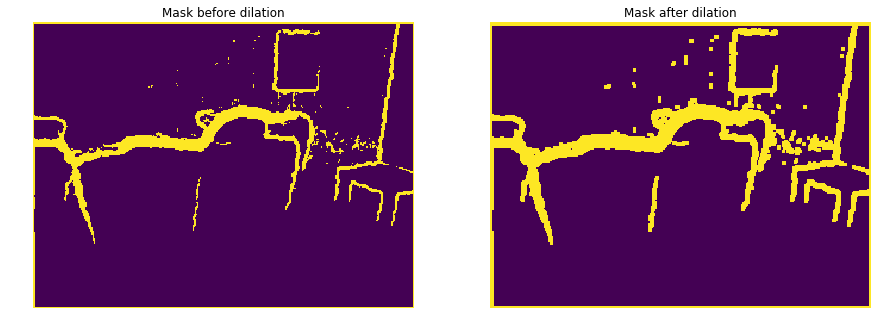

In [41]:
dilate_kernel = np.ones([3, 3])
mask_dilate = cv2.dilate(mask_sample, dilate_kernel)
mask_tensor = torch.from_numpy(mask_dilate).cuda().unsqueeze(dim=0).unsqueeze(dim=0).byte()
print(mask_tensor.shape, mask_tensor.type())

plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.title('Mask before dilation')
plt.imshow(mask_sample)
plt.axis('off')
plt.subplot(122)
plt.title('Mask after dilation')
plt.imshow(mask_dilate)
plt.axis('off')

plt.show()

Running p3d1...
Max: 0.7486065626144409, Min: 0.0


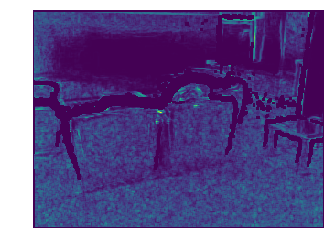

Running p3d2...
Running p5d1...
Running p7d1...
Running p9d1...
Running p5d2...
Running p11d1...
Running p13d1...
Running p7d2...


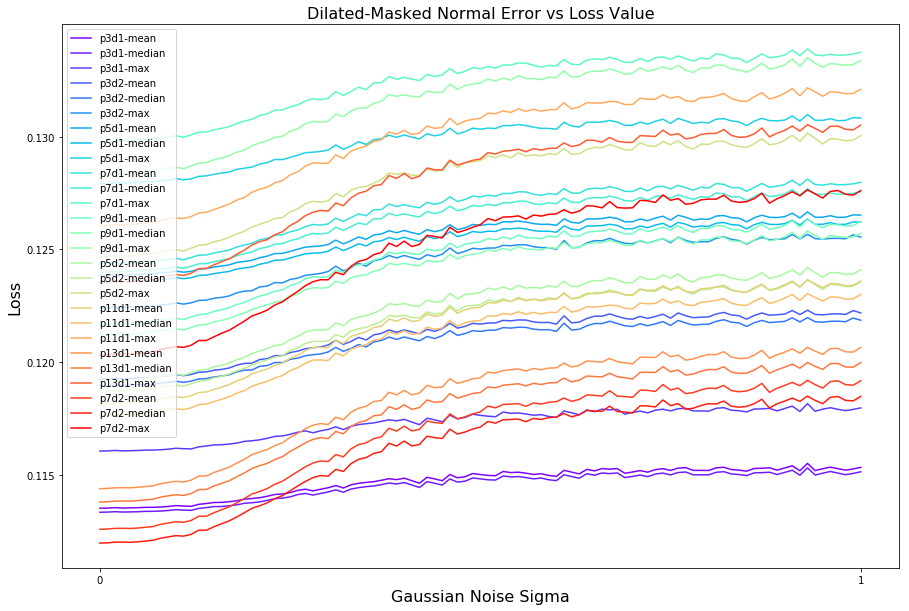

In [42]:
psize_lst = [(3, 1), (3, 2), (5, 1), (7, 1), (9, 1), (5, 2), (11, 1), (13, 1), (7, 2)]
results_masked = test_and_plot_normal_error(data, psize_lst,
                                            mask=mask_tensor,
                                            plt_title="Dilated-Masked Normal Error vs Loss Value")

In [43]:
mean_abs_diff_masked = {}
for k, v in results_masked.items():
    losses = copy.deepcopy(v)
    mean_abs_diff_masked[k] = np.mean(losses)
    
mean_abs_diff_masked = sorted(mean_abs_diff_masked.items(), key=lambda kv: kv[1], reverse=True)

# print
print("Top 10 Configurations with Largest Absolute Difference:")
for label, abs_diff in mean_abs_diff_masked[:10]:
    print("p{:2d}d{}-{:10s}: {}".format(*label, abs_diff))

Top 10 Configurations with Largest Absolute Difference:
p 7d1-max       : 0.13235384225845337
p 9d1-max       : 0.1315622180700302
p11d1-max       : 0.12991881370544434
p 5d1-max       : 0.1298356056213379
p 5d2-max       : 0.12809371948242188
p13d1-max       : 0.12797923386096954
p 7d1-mean      : 0.1267225742340088
p 7d1-median    : 0.12631817162036896
p 5d1-mean      : 0.1256123185157776
p 5d1-median    : 0.1253097951412201


In [44]:
np.save('patch_loss_mask_dilated_results.npy', results_masked)

In [45]:
results_masked = np.load('patch_loss_mask_dilated_results.npy', allow_pickle=True).item()

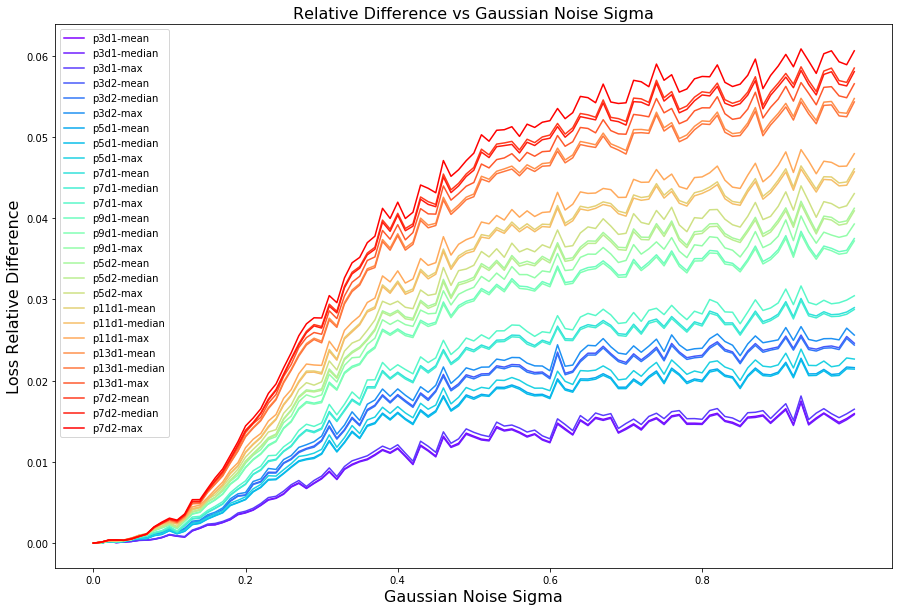

In [46]:
reduce_lst = ["mean", "median", "max"]
psize_lst = [(3, 1), (3, 2), (5, 1), (7, 1), (9, 1), (5, 2), (11, 1), (13, 1), (7, 2)]

fs = 14
plt.figure(figsize=(15, 10))
plt.title("Relative Difference vs Gaussian Noise Sigma", fontsize=fs+2)
plt.xlabel('Gaussian Noise Sigma', fontsize=fs+2)
plt.ylabel('Loss Relative Difference', fontsize=fs+2)

plt.xticks(np.arange(0, 1, step=0.2))
sigma_lst = np.arange(0, 1.01, 0.01).tolist()
#plt.xticks(np.arange(0, 6, step=0.5))
#sigma_lst = np.arange(0, 6.5, 0.5).tolist()

color=cm.rainbow(np.linspace(0, 1, len(results.keys())))

for i, (psize, dil) in enumerate(psize_lst): 
    for j, rtype in enumerate(reduce_lst):
        idx = i*len(reduce_lst) + j
        losses = copy.deepcopy(results_masked[(psize, dil, rtype)])
        base = losses[0]
        losses = [(loss-base)/base for loss in losses]
        plt.plot(sigma_lst, losses,
                 label="p{}d{}-{}".format(psize, dil, rtype),
                 c=color[idx])
        
plt.legend()
plt.show()

In [47]:
# sort according to mean relative difference
mean_rel_diff = {}
for k, v in results_masked.items():
    losses = copy.deepcopy(v)
    base = losses[0]
    mean_rel_diff[k] = np.mean([(loss-base)/base for loss in losses])
    
# sort 
mean_rel_diff = sorted(mean_rel_diff.items(), key=lambda kv: kv[1], reverse=True)

# print
print("Top 10 Configurations with Largest Relative Difference:")
for label, rel in mean_rel_diff[:10]:
    print("p{:2d}d{}-{:10s}: {}".format(*label, rel))

Top 10 Configurations with Largest Relative Difference:
p 7d2-max       : 0.03871947154402733
p 7d2-mean      : 0.03733813017606735
p 7d2-median    : 0.03706784173846245
p13d1-max       : 0.03610473498702049
p13d1-mean      : 0.0349394828081131
p13d1-median    : 0.03467853367328644
p11d1-max       : 0.03066866472363472
p11d1-mean      : 0.029461566358804703
p11d1-median    : 0.02922985516488552
p 5d2-max       : 0.027472293004393578
